In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class MakeClass(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        uniques = torch.unique(x, sorted = True)
        for i, v in enumerate(uniques):
            x[x == v] = i
        return x.to(dtype=torch.long)

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
        MakeClass()
    ]
)

train_ds = OxfordIIITPet(
    root = "~/data", split = "trainval", target_types = "segmentation", transform = transform, 
    target_transform = target_transform, 
    download = True
)

test_ds = OxfordIIITPet(
    root = "~/data", split = "test", target_types = "segmentation", transform = transform, 
    target_transform = target_transform, 
    download = True
)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

#Training Samples: 3680
#Testing Samples: 3669
#Training Batch: 58
#Testing Batch: 58


In [4]:
sample_data, sample_mask = train_ds[100]

print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")

print(f"Number classes: {np.unique(sample_mask.numpy())}")

data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([1, 256, 256])
Number classes: [0 1 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


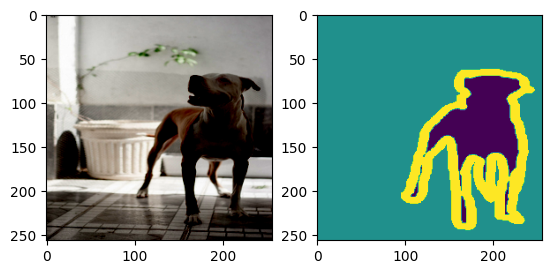

In [5]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(sample_data.cpu().permute(1, -1, 0).numpy())
axarr[1].imshow(sample_mask.cpu().permute(1, -1, 0).numpy())

In [6]:
class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

In [7]:
class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x


class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [8]:
class AttU_Net(nn.Module):
    """https://arxiv.org/abs/1804.03999"""
    def __init__(self, img_ch=3, output_ch=3, ini_filter = 16):
        super(AttU_Net, self).__init__()

        n1 = ini_filter
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)        
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

In [9]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = AttU_Net().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [12]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device, dtype = torch.long)

        train_gen_mask = model(train_img)
        train_rec_loss = loss_fn(train_gen_mask, train_mask.squeeze(1))
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            F.one_hot(train_mask.squeeze(1), 3).permute(0, 3, 1, 2).float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(test_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device, dtype = torch.long)
            
            valid_gen_mask = model(valid_img)
            valid_loss = loss_fn(valid_gen_mask, valid_mask.squeeze(1))
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                F.one_hot(valid_mask.squeeze(1), 3).permute(0, 3, 1, 2).float(),
                multiclass=True
            )
            valid_loss = train_rec_loss + train_dice_loss

            va_total_loss += valid_loss.item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.09it/s]


Epoch: 0 - TrainLoss: 1.3628026555324424 - ValidLoss: 1.1123876571655273


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.25it/s]


Epoch: 1 - TrainLoss: 0.9300002106304827 - ValidLoss: 0.7698311805725098


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.10it/s]


Epoch: 2 - TrainLoss: 0.7377251561345726 - ValidLoss: 0.6660546660423279


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.14it/s]


Epoch: 3 - TrainLoss: 0.656845879965815 - ValidLoss: 0.6128504276275635


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.28it/s]


Epoch: 4 - TrainLoss: 0.6018730186182877 - ValidLoss: 0.512073278427124


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.33it/s]


Epoch: 5 - TrainLoss: 0.5642122826699553 - ValidLoss: 0.49266356229782104


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.07it/s]


Epoch: 6 - TrainLoss: 0.5349572033717714 - ValidLoss: 0.7292943000793457


100%|██████████████████████████████████████████████████████| 58/58 [00:06<00:00,  8.29it/s]


Epoch: 7 - TrainLoss: 0.5128678355751366 - ValidLoss: 0.5284109115600586


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.98it/s]


Epoch: 8 - TrainLoss: 0.4780814205778056 - ValidLoss: 0.474338561296463


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.05it/s]


Epoch: 9 - TrainLoss: 0.4661573161338938 - ValidLoss: 0.4415942132472992


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.11it/s]


Epoch: 10 - TrainLoss: 0.44889976752215416 - ValidLoss: 0.6308987140655518


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.18it/s]


Epoch: 11 - TrainLoss: 0.4327685946020587 - ValidLoss: 0.5082153081893921


100%|██████████████████████████████████████████████████████| 58/58 [00:06<00:00,  8.37it/s]


Epoch: 12 - TrainLoss: 0.42318728155103225 - ValidLoss: 0.4468616545200348


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.07it/s]


Epoch: 13 - TrainLoss: 0.4005977305872687 - ValidLoss: 0.3872745633125305


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.11it/s]


Epoch: 14 - TrainLoss: 0.37380967931500797 - ValidLoss: 0.43264997005462646


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.23it/s]


Epoch: 15 - TrainLoss: 0.3753308206796646 - ValidLoss: 0.36363059282302856


100%|██████████████████████████████████████████████████████| 58/58 [00:06<00:00,  8.38it/s]


Epoch: 16 - TrainLoss: 0.35571671714042796 - ValidLoss: 0.3500230312347412


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.27it/s]


Epoch: 17 - TrainLoss: 0.34413727912409553 - ValidLoss: 0.3484758138656616


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.21it/s]


Epoch: 18 - TrainLoss: 0.32702757007089156 - ValidLoss: 0.27410387992858887


100%|██████████████████████████████████████████████████████| 58/58 [00:06<00:00,  8.44it/s]


Epoch: 19 - TrainLoss: 0.3123962406454415 - ValidLoss: 0.28562822937965393


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.24it/s]


Epoch: 20 - TrainLoss: 0.3190121594174155 - ValidLoss: 0.4048841595649719


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.18it/s]


Epoch: 21 - TrainLoss: 0.32316207474675673 - ValidLoss: 0.3265500068664551


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.12it/s]


Epoch: 22 - TrainLoss: 0.2993955920482504 - ValidLoss: 0.32786691188812256


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.19it/s]


Epoch: 23 - TrainLoss: 0.2838984244856341 - ValidLoss: 0.26439228653907776


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.05it/s]


Epoch: 24 - TrainLoss: 0.2768549379603616 - ValidLoss: 0.28749027848243713


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.04it/s]


Epoch: 25 - TrainLoss: 0.2754879008079397 - ValidLoss: 0.24763791263103485


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.15it/s]


Epoch: 26 - TrainLoss: 0.2562493612540179 - ValidLoss: 0.2354399561882019


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.03it/s]


Epoch: 27 - TrainLoss: 0.2522403197041873 - ValidLoss: 0.26782363653182983


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.19it/s]


Epoch: 28 - TrainLoss: 0.25582834384564695 - ValidLoss: 0.2750130891799927


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.28it/s]


Epoch: 29 - TrainLoss: 0.24549961809454293 - ValidLoss: 0.23555096983909607


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.77it/s]


Epoch: 30 - TrainLoss: 0.2384225351029429 - ValidLoss: 0.23017030954360962


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.37it/s]


Epoch: 31 - TrainLoss: 0.23420877651921634 - ValidLoss: 0.2242162972688675


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.21it/s]


Epoch: 32 - TrainLoss: 0.22353442578480162 - ValidLoss: 0.19783616065979004


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.09it/s]


Epoch: 33 - TrainLoss: 0.2153492151149388 - ValidLoss: 0.35789772868156433


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.81it/s]


Epoch: 34 - TrainLoss: 0.2091929110987433 - ValidLoss: 0.20813022553920746


100%|██████████████████████████████████████████████████████| 58/58 [00:06<00:00,  8.39it/s]


Epoch: 35 - TrainLoss: 0.20519544132824602 - ValidLoss: 0.26284998655319214


100%|██████████████████████████████████████████████████████| 58/58 [00:06<00:00,  8.29it/s]


Epoch: 36 - TrainLoss: 0.20238358578805266 - ValidLoss: 0.21061624586582184


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.13it/s]


Epoch: 37 - TrainLoss: 0.19456013523299118 - ValidLoss: 0.18301939964294434


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.09it/s]


Epoch: 38 - TrainLoss: 0.1921601020570459 - ValidLoss: 0.17924931645393372


100%|██████████████████████████████████████████████████████| 58/58 [00:06<00:00,  8.37it/s]


Epoch: 39 - TrainLoss: 0.19251283515116263 - ValidLoss: 0.20648837089538574


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.25it/s]


Epoch: 40 - TrainLoss: 0.1909404818353982 - ValidLoss: 0.20167657732963562


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.25it/s]


Epoch: 41 - TrainLoss: 0.1921348818417253 - ValidLoss: 0.21175247430801392


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.24it/s]


Epoch: 42 - TrainLoss: 0.18708972504426694 - ValidLoss: 0.18424031138420105


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.14it/s]


Epoch: 43 - TrainLoss: 0.19970375710520252 - ValidLoss: 0.23079262673854828


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.21it/s]


Epoch: 44 - TrainLoss: 0.19652894627431344 - ValidLoss: 0.18185502290725708


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.18it/s]


Epoch: 45 - TrainLoss: 0.18241782794738637 - ValidLoss: 0.1768002212047577


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.20it/s]


Epoch: 46 - TrainLoss: 0.17037702480266834 - ValidLoss: 0.169072687625885


100%|██████████████████████████████████████████████████████| 58/58 [00:06<00:00,  8.35it/s]


Epoch: 47 - TrainLoss: 0.16419695934344983 - ValidLoss: 0.17358285188674927


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.19it/s]


Epoch: 48 - TrainLoss: 0.160856532382554 - ValidLoss: 0.16997599601745605


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.12it/s]


Epoch: 49 - TrainLoss: 0.15769509971141815 - ValidLoss: 0.1537468433380127


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.94it/s]


Epoch: 50 - TrainLoss: 0.15371336916397357 - ValidLoss: 0.1466853767633438


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.13it/s]


Epoch: 51 - TrainLoss: 0.1506133845140194 - ValidLoss: 0.1646188497543335


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.40it/s]


Epoch: 52 - TrainLoss: 0.14894386457985845 - ValidLoss: 0.1473338007926941


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.04it/s]


Epoch: 53 - TrainLoss: 0.14605434418752275 - ValidLoss: 0.15217944979667664


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.10it/s]


Epoch: 54 - TrainLoss: 0.14387383311986923 - ValidLoss: 0.15838119387626648


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.87it/s]


Epoch: 55 - TrainLoss: 0.14134030634986944 - ValidLoss: 0.14814922213554382


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.96it/s]


Epoch: 56 - TrainLoss: 0.13807019848248053 - ValidLoss: 0.12774856388568878


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.13it/s]


Epoch: 57 - TrainLoss: 0.1351955895280016 - ValidLoss: 0.14176306128501892


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.17it/s]


Epoch: 58 - TrainLoss: 0.13219302507310077 - ValidLoss: 0.13511814177036285


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.23it/s]


Epoch: 59 - TrainLoss: 0.12973123891600247 - ValidLoss: 0.13330760598182678


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.13it/s]


Epoch: 60 - TrainLoss: 0.12838327036849384 - ValidLoss: 0.12539851665496826


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.11it/s]


Epoch: 61 - TrainLoss: 0.1261883430696767 - ValidLoss: 0.13413579761981964


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.12it/s]


Epoch: 62 - TrainLoss: 0.12416358690323501 - ValidLoss: 0.1356213390827179


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.16it/s]


Epoch: 63 - TrainLoss: 0.12148681539913704 - ValidLoss: 0.134706512093544


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.14it/s]


Epoch: 64 - TrainLoss: 0.1197079806749163 - ValidLoss: 0.1243317574262619


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.20it/s]


Epoch: 65 - TrainLoss: 0.11909399310062671 - ValidLoss: 0.11568689346313477


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.16it/s]


Epoch: 66 - TrainLoss: 0.11554712468180163 - ValidLoss: 0.11352366954088211


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.23it/s]


Epoch: 67 - TrainLoss: 0.11450680242530231 - ValidLoss: 0.11895103007555008


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.12it/s]


Epoch: 68 - TrainLoss: 0.11373283431447785 - ValidLoss: 0.1273001730442047


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.17it/s]


Epoch: 69 - TrainLoss: 0.11615563852005992 - ValidLoss: 0.12127155810594559


100%|██████████████████████████████████████████████████████| 58/58 [00:06<00:00,  8.32it/s]


Epoch: 70 - TrainLoss: 0.1119737034213954 - ValidLoss: 0.10761351138353348


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.08it/s]


Epoch: 71 - TrainLoss: 0.1081257572975652 - ValidLoss: 0.12431766837835312


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.11it/s]


Epoch: 72 - TrainLoss: 0.10662901876815434 - ValidLoss: 0.11927828937768936


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.28it/s]


Epoch: 73 - TrainLoss: 0.1055736318230629 - ValidLoss: 0.10229936242103577


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.54it/s]


Epoch: 74 - TrainLoss: 0.10417802670392497 - ValidLoss: 0.10383401066064835


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.46it/s]


Epoch: 75 - TrainLoss: 0.10285300620157144 - ValidLoss: 0.11329597234725952


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.16it/s]


Epoch: 76 - TrainLoss: 0.10155705940620653 - ValidLoss: 0.099161796271801


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.04it/s]


Epoch: 77 - TrainLoss: 0.10057688941215646 - ValidLoss: 0.0997573584318161


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.94it/s]


Epoch: 78 - TrainLoss: 0.09953057688885722 - ValidLoss: 0.10609763115644455


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.25it/s]


Epoch: 79 - TrainLoss: 0.09906154909524424 - ValidLoss: 0.10866005718708038


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.10it/s]


Epoch: 80 - TrainLoss: 0.09735131739028569 - ValidLoss: 0.1017003208398819


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.23it/s]


Epoch: 81 - TrainLoss: 0.09699136725273626 - ValidLoss: 0.10110742598772049


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.20it/s]


Epoch: 82 - TrainLoss: 0.09620955997499926 - ValidLoss: 0.09839987009763718


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.02it/s]


Epoch: 83 - TrainLoss: 0.09506028029939224 - ValidLoss: 0.09430576860904694


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.98it/s]


Epoch: 84 - TrainLoss: 0.09562367213697269 - ValidLoss: 0.10862576961517334


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.12it/s]


Epoch: 85 - TrainLoss: 0.09463925210052523 - ValidLoss: 0.11061788350343704


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.18it/s]


Epoch: 86 - TrainLoss: 0.093645962533252 - ValidLoss: 0.0944710522890091


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.18it/s]


Epoch: 87 - TrainLoss: 0.0933589001410994 - ValidLoss: 0.09899722784757614


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.06it/s]


Epoch: 88 - TrainLoss: 0.09251038177773871 - ValidLoss: 0.09877154231071472


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.25it/s]


Epoch: 89 - TrainLoss: 0.0928794214951581 - ValidLoss: 0.10986145585775375


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.17it/s]


Epoch: 90 - TrainLoss: 0.09214901615833414 - ValidLoss: 0.08987666666507721


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.08it/s]


Epoch: 91 - TrainLoss: 0.0912842002922091 - ValidLoss: 0.09668789803981781


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.21it/s]


Epoch: 92 - TrainLoss: 0.09224729227094815 - ValidLoss: 0.1093890592455864


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.43it/s]


Epoch: 93 - TrainLoss: 0.0916841852253881 - ValidLoss: 0.09552343934774399


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.59it/s]


Epoch: 94 - TrainLoss: 0.09195288591857614 - ValidLoss: 0.08833753317594528


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.07it/s]


Epoch: 95 - TrainLoss: 0.09153299830083189 - ValidLoss: 0.10012774914503098


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.05it/s]


Epoch: 96 - TrainLoss: 0.09181183383896432 - ValidLoss: 0.09859680384397507


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.89it/s]


Epoch: 97 - TrainLoss: 0.09101947859443467 - ValidLoss: 0.09466558694839478


100%|██████████████████████████████████████████████████████| 58/58 [00:06<00:00,  8.39it/s]


Epoch: 98 - TrainLoss: 0.09064694828000562 - ValidLoss: 0.0907459482550621


100%|██████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.20it/s]

Epoch: 99 - TrainLoss: 0.09077312206399851 - ValidLoss: 0.09315651655197144


<All keys matched successfully>

  0%|                                                               | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 10%|█████▌                                                 | 1/10 [00:00<00:01,  8.80it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 30%|████████████████▌                                      | 3/10 [00:00<00:00, 13.58it/s]Clipping input data to the valid range for imshow with RGB data ([0

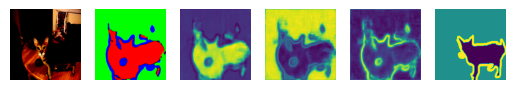

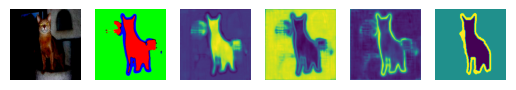

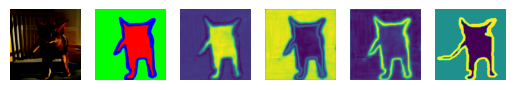

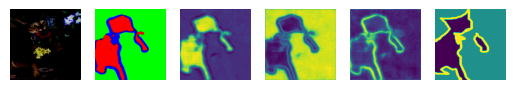

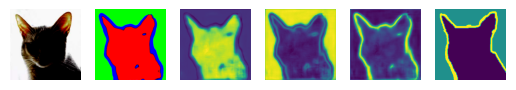

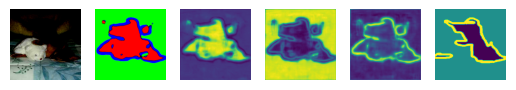

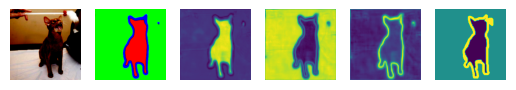

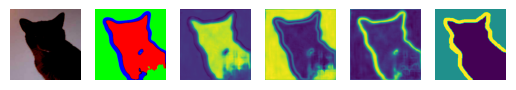

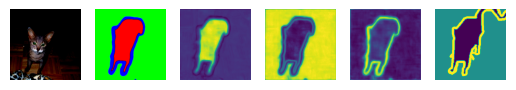

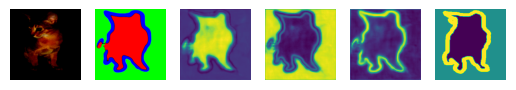

In [13]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     

        f, axarr = plt.subplots(1, 6)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(gen_mask[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(gen_mask[0][0].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        axarr[3].imshow(gen_mask[0][1].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[3].axis('off')
        axarr[4].imshow(gen_mask[0][2].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[4].axis('off')
        axarr[5].imshow(valid_mask.cpu().permute(1, -1, 0).numpy())
        axarr[5].axis('off')